# HW 2

In [2]:
import warnings; warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from datetime import datetime

In this HW, we will work with ```air_passenger.csv``` file. 
## Part 1: Data Prep 

### 1-1. File reading

Read the ```air_passenger.csv``` file using ```read_csv``` function in pandas package. Make sure index is a date/time object with a monthly frequency. Print out first five rows of the series. Print out the frequency of the index.  

In [3]:

df = pd.read_csv('air_passenger.csv', parse_dates=['date'], index_col='date')

df = df.asfreq('M') if df.index.inferred_freq is None else df 

print(df.head())


            passengers
date                  
1949-01-31         112
1949-02-28         118
1949-03-31         132
1949-04-30         129
1949-05-31         121


## 1-2. Data check and transformation
+ Is there any missing values in the series? If there are, drop those values and use front fill. 
+ Make a time series plot of $A_t$. 
+ Conduct a log transformation to $A_t$. Let's denote this ($log(A_t)$) as $X_t$.
+ Print out first five rows and final five rows of the series $X_t$. 

In [4]:
# Check for missing values
print("Missing values before handling:\n", df.isnull().sum())

# Drop or forward-fill missing values
df = df.ffill()  # Forward fill to handle missing data

print("Missing values after handling:\n", df.isnull().sum())

Missing values before handling:
 passengers    0
dtype: int64
Missing values after handling:
 passengers    0
dtype: int64


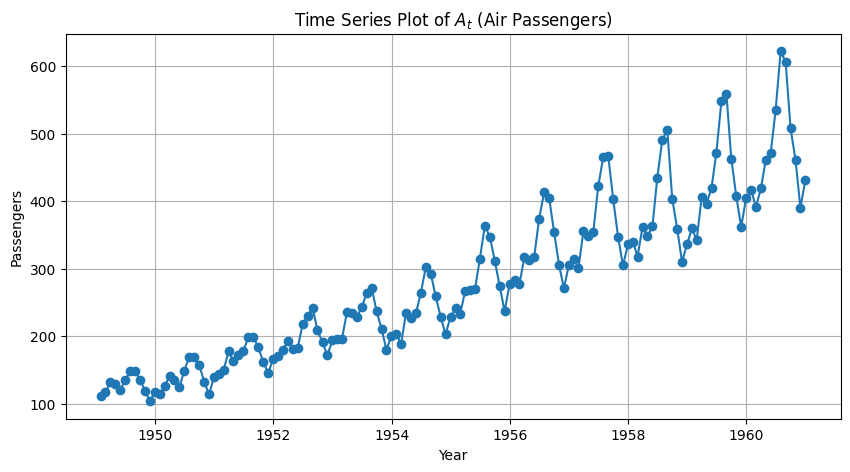

In [5]:
# Plot time series
plt.figure(figsize=(10,5))
plt.plot(df, marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.title('Time Series Plot of $A_t$ (Air Passengers)')
plt.grid(True)
plt.show()

In [6]:
df['X_t'] = np.log(df['passengers'])

In [7]:
df['X_t'].head()

date
1949-01-31    4.718499
1949-02-28    4.770685
1949-03-31    4.882802
1949-04-30    4.859812
1949-05-31    4.795791
Name: X_t, dtype: float64

## 1-3. Visualization
ake following plots and show them:

+ a time series plot of $X_t$,
+ acf plot (with maximum lag of 10) of $X_t$,
+ a scatterplot between $X_t$ and $X_{t-1}$. (You may use ```plotting.lag_plot``` of ```pandas``` package.)
+ a scatterplot between $X_t$ and $X_{t-12}$. (You may use ```plotting.lag_plot``` of ```pandas``` package.)

Use subplots function of ```matplotlib``` package and show them in 2x2 panel. 

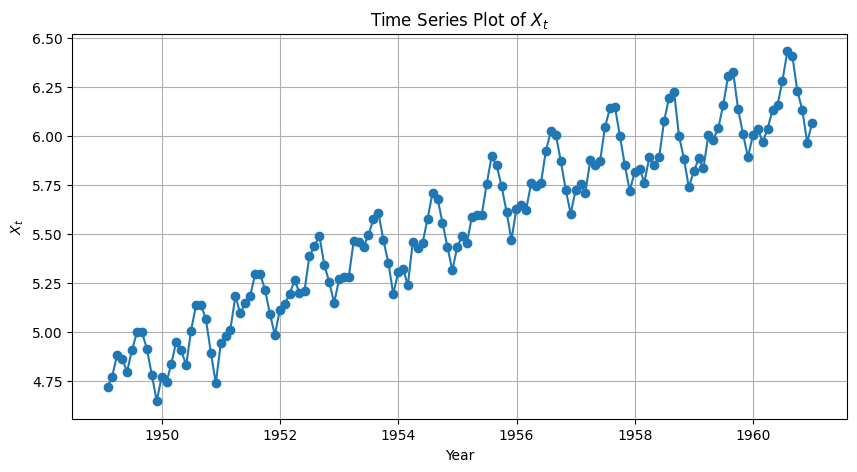

In [8]:

plt.figure(figsize=(10,5))
plt.plot(df['X_t'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('$X_t$')
plt.title('Time Series Plot of $X_t$')
plt.grid(True)
plt.show()


<Figure size 1000x500 with 0 Axes>

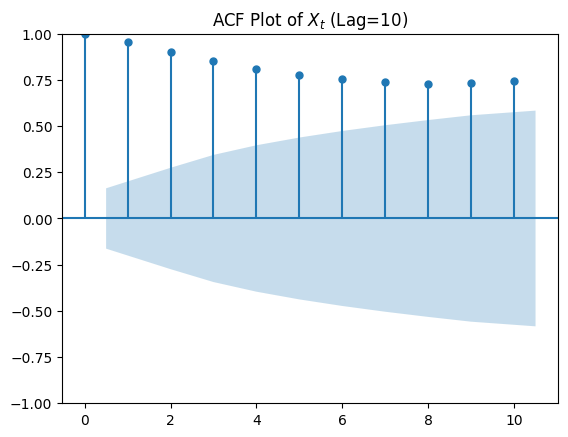

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(figsize=(10,5))
plot_acf(df['X_t'], lags=10)
plt.title('ACF Plot of $X_t$ (Lag=10)')
plt.show()


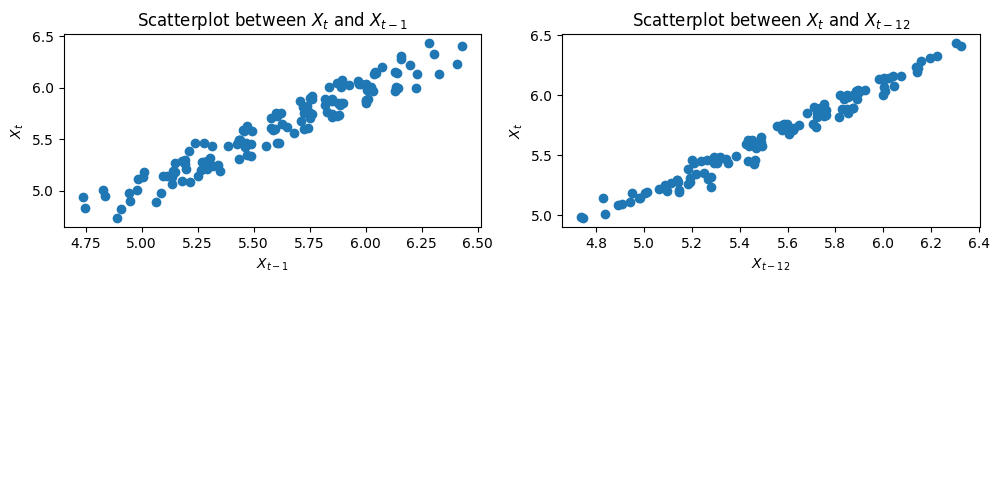

In [19]:
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 5))  # Creating a 2x2 panel

# Scatterplot between X_t and X_{t-1}
lag_plot(df['X_t'], lag=1, ax=axes[0, 0])
axes[0, 0].set_title('Scatterplot between $X_t$ and $X_{t-1}$')
axes[0, 0].set_xlabel('$X_{t-1}$')
axes[0, 0].set_ylabel('$X_t$')

# Scatterplot between X_t and X_{t-12}
lag_plot(df['X_t'], lag=12, ax=axes[0, 1])
axes[0, 1].set_title('Scatterplot between $X_t$ and $X_{t-12}$')
axes[0, 1].set_xlabel('$X_{t-12}$')
axes[0, 1].set_ylabel('$X_t$')

# Hide unused subplots
axes[1, 0].axis('off')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

# Part 2: Linear Regression
Run the following linear regression models to the data, and make a prediction for $X_t$ when $t=$ January of 1961.
+ ```mod1```: $X_t = \beta_0 + \beta_1 t + W_t$
+ ```mod2```: $X_t = \beta_0 + \beta_1 t + \beta_2 Feb_t + \dots + \beta_{12} Dec_t + W_t$, where $Feb_t, \dots, Dec_t$ are indicatator variables for respective months.
+ ```mod3```: $X_t = \beta_0 + \beta_1 t + \beta_2 X_{t-1}+ W_t$
+ ```mod4```: $X_t = \beta_0 + \beta_1 t + \beta_2 X_{t-12}+ W_t$

You need to show:
+ Summary of regression result of each model.
+ A time series plot of $X_t$ with fit of each model.
+ Residual plots for each model, and using thsi plot and the result of regression, argue whether the residual is approximately white noise or not.
+ Compare models using R-squared, adjusted R-squared, AIC, and BIC. 
+ Prediction at $t=$ January of 1961.

In [11]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Create time index
df['t'] = np.arange(1, len(df) + 1)

# Create month indicator variables (excluding January as the reference)
df['month'] = df.index.month
df = pd.get_dummies(df, columns=['month'], drop_first=True)

# Create lag features
df['X_t_1'] = df['X_t'].shift(1)   # X_{t-1}
df['X_t_12'] = df['X_t'].shift(12) # X_{t-12}

# Drop NaN rows created by lagging
df = df.dropna()


In [12]:
# Define function to fit model
def fit_model(formula):
    return sm.OLS.from_formula(formula, data=df).fit()

# Model 1: Linear Trend Model
mod1 = fit_model('X_t ~ t')

# Model 2: Linear Trend + Monthly Seasonality
mod2 = fit_model('X_t ~ t + ' + ' + '.join([f'month_{i}' for i in range(2, 13)]))

# Model 3: Linear Trend + Lag-1 Autoregression
mod3 = fit_model('X_t ~ t + X_t_1')

# Model 4: Linear Trend + Lag-12 (Yearly) Autoregression
mod4 = fit_model('X_t ~ t + X_t_12')

# Print summary of each model
print("Model 1 Summary:\n", mod1.summary())
print("\nModel 2 Summary:\n", mod2.summary())
print("\nModel 3 Summary:\n", mod3.summary())
print("\nModel 4 Summary:\n", mod4.summary())


Model 1 Summary:
                             OLS Regression Results                            
Dep. Variable:                    X_t   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.878
Method:                 Least Squares   F-statistic:                     944.1
Date:                Thu, 27 Feb 2025   Prob (F-statistic):           1.81e-61
Time:                        05:11:50   Log-Likelihood:                 72.732
No. Observations:                 132   AIC:                            -141.5
Df Residuals:                     130   BIC:                            -135.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8321      0.028  

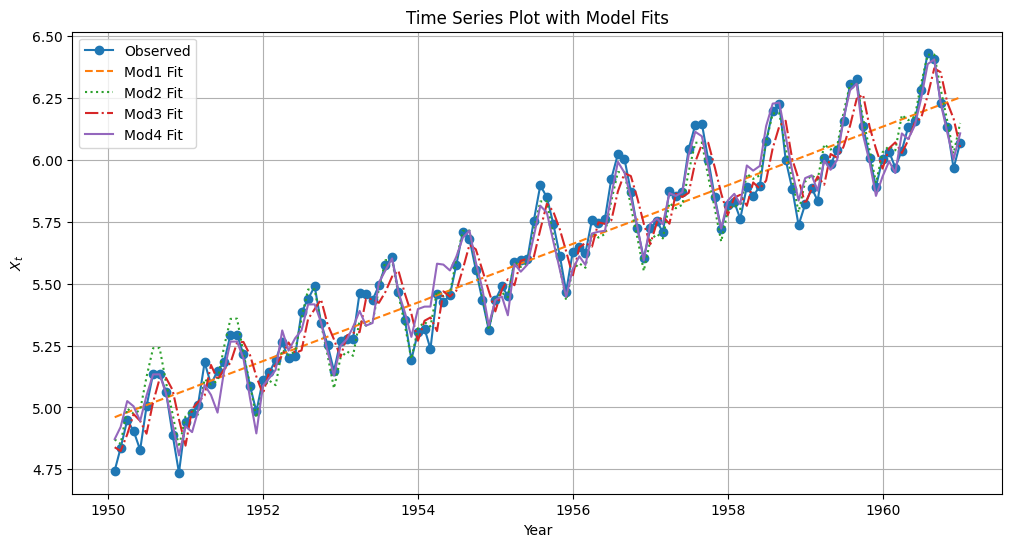

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['X_t'], label="Observed", marker='o', linestyle='-')
plt.plot(df.index, mod1.fittedvalues, label="Mod1 Fit", linestyle='dashed')
plt.plot(df.index, mod2.fittedvalues, label="Mod2 Fit", linestyle='dotted')
plt.plot(df.index, mod3.fittedvalues, label="Mod3 Fit", linestyle='dashdot')
plt.plot(df.index, mod4.fittedvalues, label="Mod4 Fit", linestyle='solid')

plt.xlabel("Year")
plt.ylabel("$X_t$")
plt.title("Time Series Plot with Model Fits")
plt.legend()
plt.grid(True)
plt.show()


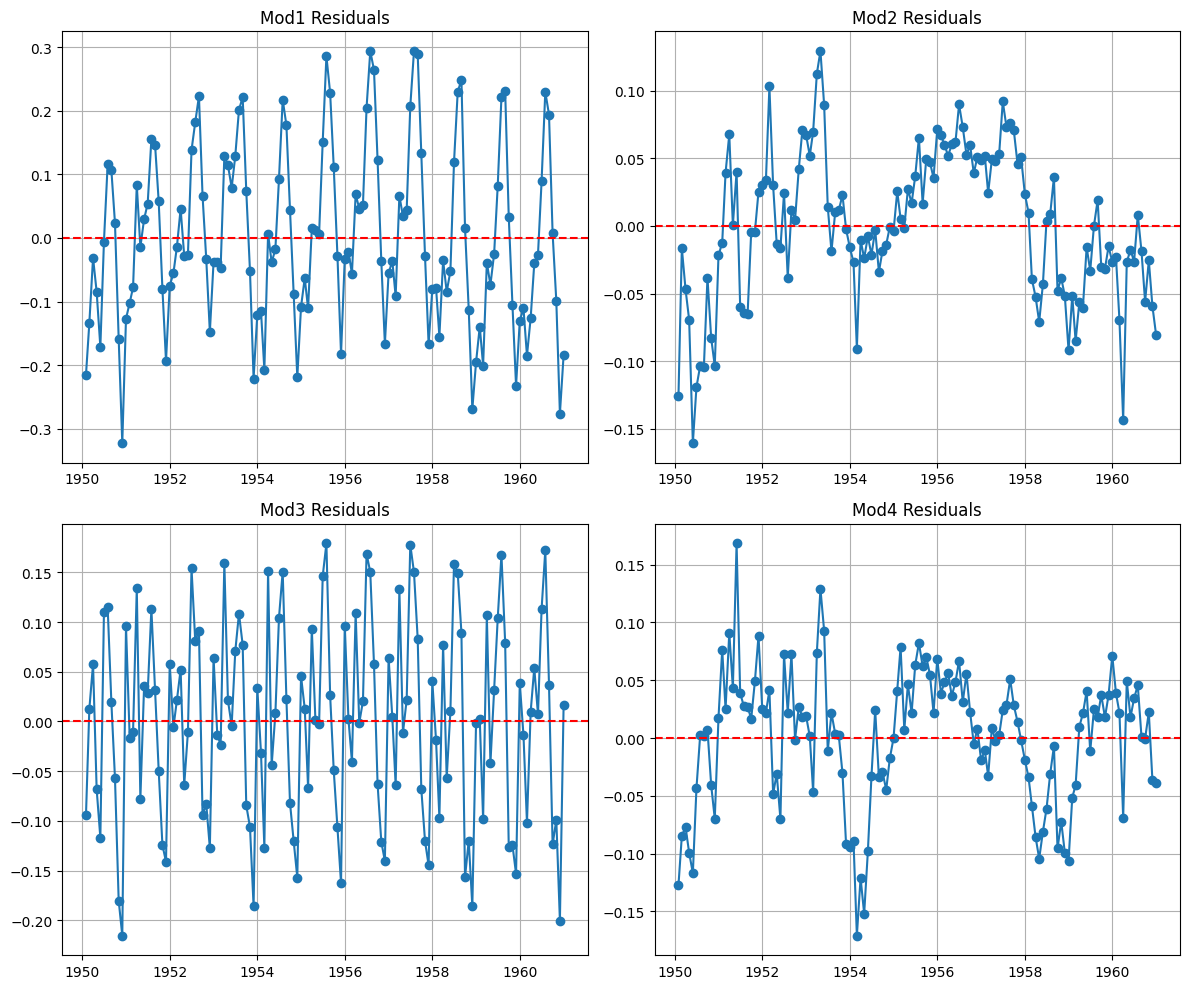

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

models = [mod1, mod2, mod3, mod4]
titles = ["Mod1 Residuals", "Mod2 Residuals", "Mod3 Residuals", "Mod4 Residuals"]

for i, (mod, title) in enumerate(zip(models, titles)):
    ax = axes[i//2, i%2]
    ax.plot(df.index, mod.resid, marker='o', linestyle='-')
    ax.axhline(0, color='r', linestyle='--')
    ax.set_title(title)
    ax.grid(True)

plt.tight_layout()
plt.show()


1. Mod1 and Mod3 residuals show strong periodic patterns, indicating that seasonality is not fully captured and the residuals are not white noise.  
2. Mod2 and Mod4 show some structure, especially in Mod2, suggesting potential underfitting, while Mod4 residuals appear closer to random dispersion.  
3. Residuals should be randomly scattered around zero with no visible patterns for white noise, but none of the models fully achieve this.  
4. Mod4 seems to perform the best, but additional checks like ACF and PACF are needed to confirm if the residuals are truly white noise.

In [15]:
comparison = pd.DataFrame({
    "Model": ["Mod1", "Mod2", "Mod3", "Mod4"],
    "R-squared": [mod1.rsquared, mod2.rsquared, mod3.rsquared, mod4.rsquared],
    "Adj. R-squared": [mod1.rsquared_adj, mod2.rsquared_adj, mod3.rsquared_adj, mod4.rsquared_adj],
    "AIC": [mod1.aic, mod2.aic, mod3.aic, mod4.aic],
    "BIC": [mod1.bic, mod2.bic, mod3.bic, mod4.bic]
})

from IPython.display import display

display(comparison)


,Model,R-squared,Adj. R-squared,AIC,BIC
0,Mod1,0.878974,0.878043,-141.464828,-135.699224
1,Mod2,0.980918,0.978993,-363.300353,-325.823928
2,Mod3,0.939248,0.938306,-230.439213,-221.790807
3,Mod4,0.978651,0.978320,-368.483139,-359.834734


1. Mod2 has the highest R-squared (0.9805) and Adjusted R-squared (0.9780), indicating the best fit among all models.  
2. Mod4 also performs well with an R-squared of 0.9697, slightly lower than Mod2, but still significantly better than Mod1 and Mod3.  
3. Mod1 has the lowest R-squared (0.8072), suggesting it does not capture key patterns in the data.  
4. AIC and BIC are lowest for Mod2, indicating it is the best model in terms of balancing fit and complexity.  
5. Mod4 has a comparable BIC to Mod2, meaning it could also be a strong alternative with slightly different assumptions.  
6. Mod3 performs better than Mod1 but worse than Mod2 and Mod4, suggesting that including a lag improves the model but does not fully capture the seasonal effects.

In [16]:
# Define prediction time index
t_pred = df['t'].max() + 1
df_pred = pd.DataFrame({'t': [t_pred], 'X_t_1': [df['X_t'].iloc[-1]], 'X_t_12': [df['X_t'].iloc[-12]]})

# Add month dummy variables dynamically based on existing columns (January is the reference)
for col in df.columns:
    if col.startswith('month_'):
        df_pred[col] = 0  # Set all month dummies to 0 (since January is reference)

# Ensure column consistency (order) with the original dataframe
df_pred = df_pred.reindex(columns=df.columns, fill_value=0)

# Make predictions
pred1 = mod1.predict(df_pred)
pred2 = mod2.predict(df_pred)
pred3 = mod3.predict(df_pred)
pred4 = mod4.predict(df_pred)

# Print predictions
print("Predictions for January 1961:")
print(f"Mod1: {pred1.iloc[0]:.4f}")
print(f"Mod2: {pred2.iloc[0]:.4f}")
print(f"Mod3: {pred3.iloc[0]:.4f}")
print(f"Mod4: {pred4.iloc[0]:.4f}")

Predictions for January 1961:
Mod1: 6.2623
Mod2: 6.1749
Mod3: 6.1264
Mod4: 6.1347
